In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# classifiers
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model evaluation
from sklearn.metrics import accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split

# preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

#### Goal: predict whether income exceeds $50K/yr based on census data

In [31]:
# load adult census data
url = 'https://github.com/um-perez-alvaro/Data-Science-Practice/blob/master/Data/adult_census.csv?raw=true'
census_data = pd.read_csv(url)

limit countries to the top 15 represented in the data, and group the rest into the 'other' category

In [32]:
top_countries = census_data['native-country'].value_counts().head(15).index.tolist()
census_data.loc[~census_data['native-country'].isin(top_countries), 'native-country'] = 'Other'

In [33]:
census_data.value_counts('native-country')

native-country
United-States         34214
Other                  1639
Mexico                  909
Philippines             220
Puerto-Rico             166
Germany                 155
El-Salvador             145
Canada                  125
Cuba                    109
Dominican-Republic       99
India                    98
South                    95
Jamaica                  93
China                    89
Guatemala                85
England                  83
dtype: int64

In [34]:
census_data.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,label
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K


Classification pipeline:

In [35]:
# classification pipeline
numeric_features = ['age','education-num','capitalgain','capitalloss','hoursperweek']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=1)),
    ('classifier', LR(max_iter=1000))
])

pipe_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'education-num',
                                                   'capitalgain', 'capitalloss',
                                                   'hoursperweek']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('poly_features', PolynomialFeatures(degree=1)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [36]:
census_data.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,label
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K


In [37]:
X = census_data[numeric_features + categorical_features]
y = census_data['label']
# we need to map the majority class to 0 and the minority class to 1
y = y.map({'<=50K':0, '>50K':1})
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
pipe_clf.fit(X_train,y_train)

y_pred = pipe_clf.predict(X_test)

print('accuracy:',accuracy_score(y_test,y_pred)) # percentage of correct predictions
print('balanced accuracy:',balanced_accuracy_score(y_test,y_pred)) # percentage of correct predictions (balanced)

accuracy: 0.9727585846988832
balanced accuracy: 0.5967344161609105


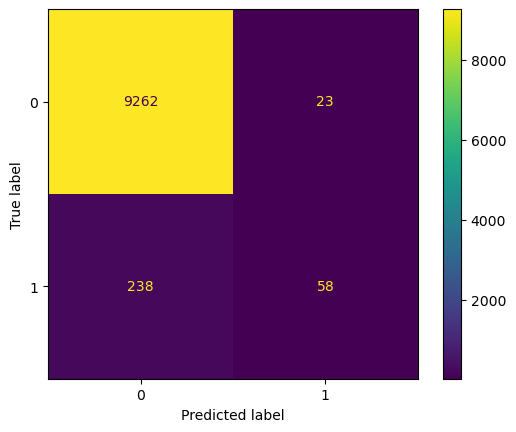

In [39]:
# confusion matrix. Model infrequently predicts label='<=50K'
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [40]:
# grid search
param_grid = {'poly_features__degree': [1,2]}
grid_search = GridSearchCV(pipe_clf, param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train,y_train)

grid_search.best_params_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[CV] END ............................poly_features__degree=1; total time=   0.7s
[CV] END ............................poly_features__degree=1; total time=   0.9s
[CV] END ............................poly_features__degree=1; total time=   1.0s
[CV] END ............................poly_features__degree=1; total time=   0.9s
[CV] END ............................poly_features__degree=1; total time=   1.0s
[CV] END ............................poly_features__degree=1; total time=   1.0s
[CV] END ............................poly_features__degree=1; total time=   1.2s
[CV] END ............................poly_features__degree=1; total time=   1.1s
[CV] END ............................poly_features__degree=1; total time=   0.8s
[CV] END ............................poly_features__degree=1; total time=   1.0s
[CV] END ............................poly_features__degree=2; total time=   5.5s
[CV] END ............................poly_features__degree=2; total time=   7.2s
[CV] END ...................

{'poly_features__degree': 2}

In [41]:
best_pipe_clf = grid_search.best_estimator_

In [42]:
# predicy using the best model
y_pred = best_pipe_clf.predict(X_test)

print('accuracy:',accuracy_score(y_test,y_pred)) # percentage of correct predictions
print('balanced accuracy:',balanced_accuracy_score(y_test,y_pred)) # percentage of correct predictions (balanced)

accuracy: 0.9734891973697943
balanced accuracy: 0.6101940793782474


Balanced accuracy as a function of the threshold

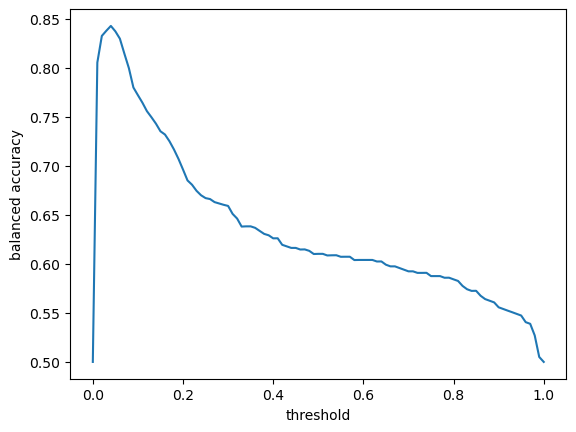

In [52]:
# balanced accuracy as a function of the threshold
proba = best_pipe_clf.predict_proba(X_test)[:,1] # [:,1] gets the second column of the array
thresholds = np.linspace(0,1,101)
balanced_accuracies = []
for thresh in thresholds:
    y_pred = np.zeros(len(y_test))
    y_pred[proba>thresh] = 1
    balanced_accuracies.append(balanced_accuracy_score(y_test,y_pred))
plt.plot(thresholds,balanced_accuracies)
plt.xlabel('threshold')
plt.ylabel('balanced accuracy')
plt.show()

In [56]:
# find the optimal_threshold
optimal_threshold = thresholds[np.argmax(balanced_accuracies)]
print('optimal threshold:',optimal_threshold)

optimal threshold: 0.04


accuracy: 0.8502244024632084
balanced accuracy: 0.8425932192289219


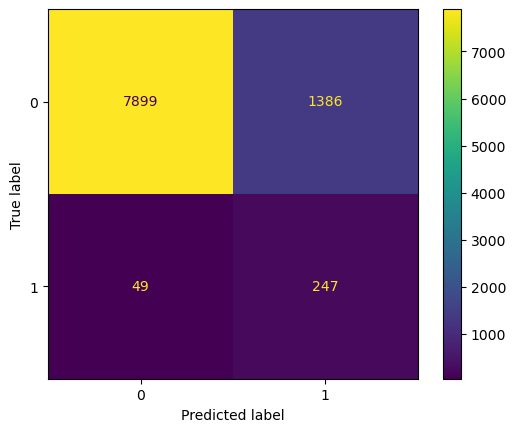

In [58]:
# predict using the optimal threshold
y_pred = np.zeros(len(y_test))
y_pred[proba>optimal_threshold] = 1
print('accuracy:',accuracy_score(y_test,y_pred)) # percentage of correct predictions
print('balanced accuracy:',balanced_accuracy_score(y_test,y_pred)) # percentage of correct predictions (balanced)

# confusion matrix - model should predict 1 (>50K) more frequently
# we pay the price of more false positives
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)